In [7]:

import numpy as np
from qiskit_aer import Aer
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler


In [2]:
def phase_oracle(n, indices_to_mark, name='Oracle'):
    qc= QuantumCircuit(n, name= name)
    oracle_matrix= np.identity(2**n)  #we define our oracle , its suppose to flip sign of the marked(|w⟩ that is give it -1 
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark]= -1 #other elements will have +1 so no change in sign
    qc.unitary(Operator(oracle_matrix),range(n))
    #the Operator(oracle_matrix) converts the oracle_matrix (which is a numpy array) into a Qiskit Operator object.
    #This object can then be used as a quantum operation within your quantum circuit.
    #When you use qc.unitary(Operator(oracle_matrix), range(n)), 
    #you're adding this oracle operation to the quantum circuit qc over n qubits
    return qc
def diffuser(n):
    qc=QuantumCircuit(n , name='Differ-"V"')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]),range(n))#It then applies the phase oracle designed to mark the ∣0⟩^⊗n state
    qc.h(range(n))
    return qc
def Grover(n,marked):
    qc=QuantumCircuit(n, n)
    r= int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state{marked} marked ,{r} rounds')
    qc.h(range(n))
    for _ in range(r):
        qc.append(phase_oracle(n,marked), range(n))
        qc.append(diffuser(n), range(n))
    qc.measure(range(n),range(n))
    return qc


5 qubits, basis state[25] marked ,4 rounds


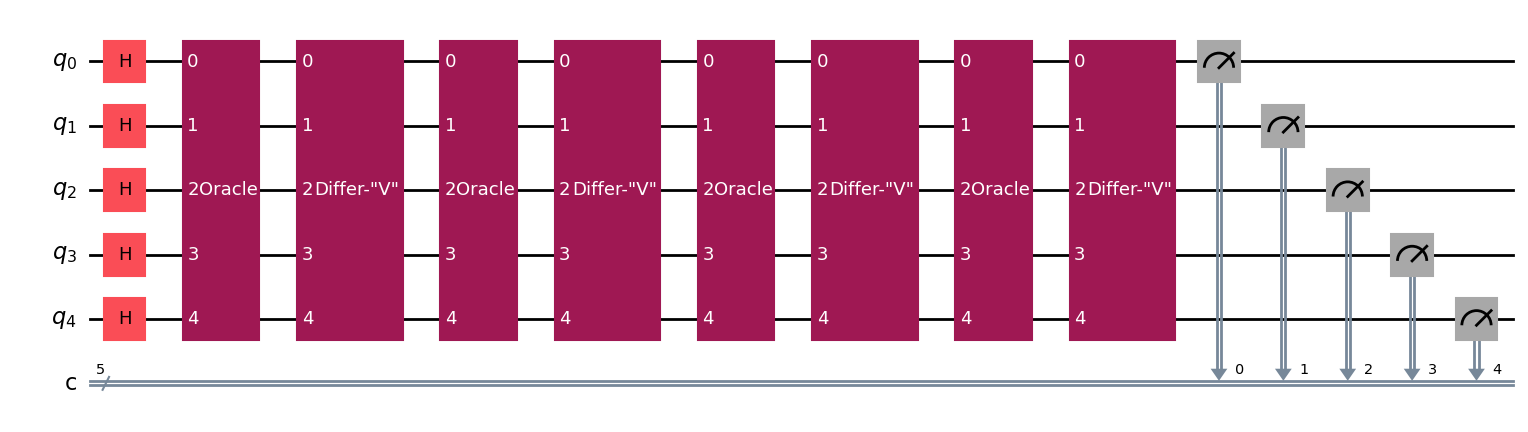

In [3]:
n= 5
x= np.random.randint(2**n)
marked =[x]
qc= Grover(n, marked)
qc.draw('mpl')


{'11010': 1, '11001': 9994, '00001': 1, '10000': 1, '10111': 1, '11111': 1, '10110': 1}
3.919534679768385


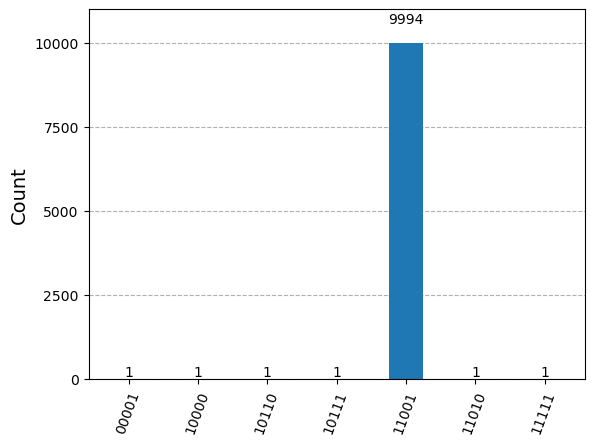

In [4]:
backend = Aer.get_backend("qasm_simulator")
tc = transpile(qc,backend)
result = backend.run(tc, shots=10000).result()
counts= result.get_counts(qc)
print(counts)
print (np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)
plot_histogram(counts)


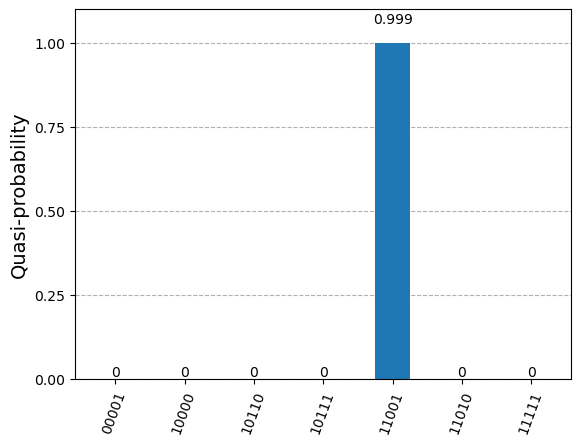

In [5]:
total_shots = sum(counts.values())
probabilities = {key: count / total_shots for key, count in counts.items()}

# Plot the histogram with probabilities
plot_histogram(probabilities)


In [8]:

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='2ce8efea0ea2f41cfe2db92f4771b22c101f583f98e4871b0893c8efb5c5cb8216928ae2ab16b108f59f79c36d5b711f5203a665cb65900e384b3a452c693f4b'
    #token='9e15651de6348bbb0bf0d12c502ab75780b008a847272ccd8bdcff8307ad4d4370c59ee4c8c4e3183ff91d6d9ab065acf06a58f82bec703275f33cd1d6dccaab'
)
backend = service.least_busy(operational=True, simulator=False)


In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)

In [11]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()

AttributeError: 'DataBin' object has no attribute 'meas'

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='2ce8efea0ea2f41cfe2db92f4771b22c101f583f98e4871b0893c8efb5c5cb8216928ae2ab16b108f59f79c36d5b711f5203a665cb65900e384b3a452c693f4b'
)
job = service.job('cxv1vcd3wrp0008kt880')

# To get counts for a particular pub result, use 
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.

In [32]:
job_result = job.result()

In [35]:
cnts=job_result[0].data.c.get_counts()
